In [4]:
import pandas as pd

### Scale data and create windows

In [40]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

data = pd.read_csv("data/merged_data.csv")
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

train_data = data[data.index.year <= 2000] #2016-12-31
test_data = data[data.index.year > 2000]


X_train, y_train = train_data.drop(columns=['Recession']), train_data['Recession']
X_test, y_test = test_data.drop(columns=['Recession']), test_data['Recession']

# Standardize training set to prevent data leakage 
# Separate columns for different scalers
standard_scaler_columns = ['Slope', 'LongTermRate' ]
min_max_scaler_columns = ['ZeroCouponYield1Y', 'ZeroCouponYield10Y']

# Apply StandardScaler to selected columns
standard_scaler = StandardScaler()
X_train[standard_scaler_columns] = standard_scaler.fit_transform(X_train[standard_scaler_columns])
X_test[standard_scaler_columns] = standard_scaler.transform(X_test[standard_scaler_columns])

# Apply MinMaxScaler to the yield data
yield_scaler = MinMaxScaler()
flat = X_train[min_max_scaler_columns].values.flatten().reshape(-1, 1) 
yield_scaler.fit(flat) # fit scaler on both collumns to calculate based on global min max
X_train[min_max_scaler_columns] = yield_scaler.transform(X_train[min_max_scaler_columns].values.flatten().reshape(-1, 1)).reshape(len(X_train), 2)
X_test[min_max_scaler_columns] = yield_scaler.transform(X_test[min_max_scaler_columns].values.flatten().reshape(-1, 1)).reshape(len(X_test), 2)


# Save scaler 
joblib.dump(standard_scaler, 'std_scaler.pkl')
joblib.dump(yield_scaler, 'yield_scaler.pkl')

def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i + window_size].values) 
        y.append(target.iloc[i + window_size - 1]) # target is the value that comes at the end of the window
    return np.array(X), np.array(y)



# Create sequences
window_size = 4
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

# Check the shapes of the generated sequences
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

y_test NaNs: 0
X_train_seq shape: (394, 4, 7)
y_train_seq shape: (394,)
X_test_seq shape: (266, 4, 7)
y_test_seq shape: (266,)


### Train model with hyperparam tuning

In [24]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping



def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('units_lstm1', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=True,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_lstm1', min_value=0.0, max_value=0.4, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(
        units=hp.Int('units_lstm2', min_value=32, max_value=256, step=32),
        activation='tanh',
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_lstm2', min_value=0.0, max_value=0.4, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=100,  
    executions_per_trial=1,  
    directory='lstm_tuning',
    project_name='binary_classification_lstm'
)


# Search for the best hyperparameters
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ],
    verbose=1


)


Trial 100 Complete [00h 00m 17s]
val_loss: 0.17434382438659668

Best val_loss So Far: 0.11681408435106277
Total elapsed time: 00h 19m 02s


### Train best model

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Units LSTM1: {best_hps.get('units_lstm1')}
- Dropout LSTM1: {best_hps.get('dropout_lstm1')}
- Units LSTM2: {best_hps.get('units_lstm2')}
- Dropout LSTM2: {best_hps.get('dropout_lstm2')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ModelCheckpoint(filepath='best_classification_model2.h5', save_best_only=True, verbose=1)
    ],
    verbose=1
)



best_model.save("best_classification_model2.h5")




Best Hyperparameters:
- Units LSTM1: 192
- Dropout LSTM1: 0.1
- Units LSTM2: 224
- Dropout LSTM2: 0.0
- Learning Rate: 0.009871011784920034

Epoch 1/100
10/13 [======================>.......] - ETA: 0s - loss: 0.3747 - accuracy: 0.8750
Epoch 1: val_loss improved from inf to 0.30539, saving model to best_classification_model2.h5
13/13 [==============================] - 3s 66ms/step - loss: 0.3410 - accuracy: 0.8858 - val_loss: 0.3054 - val_accuracy: 0.8496
Epoch 2/100
11/13 [========================>.....] - ETA: 0s - loss: 0.2253 - accuracy: 0.8892
Epoch 2: val_loss improved from 0.30539 to 0.17503, saving model to best_classification_model2.h5
13/13 [==============================] - 0s 13ms/step - loss: 0.2268 - accuracy: 0.8909 - val_loss: 0.1750 - val_accuracy: 0.9323
Epoch 3/100
11/13 [========================>.....] - ETA: 0s - loss: 0.2181 - accuracy: 0.9062
Epoch 3: val_loss did not improve from 0.17503
13/13 [==============================] - 0s 9ms/step - loss: 0.2107 - accu

### Evaluate Model

21/21 [==============================] - 3s 9ms/step


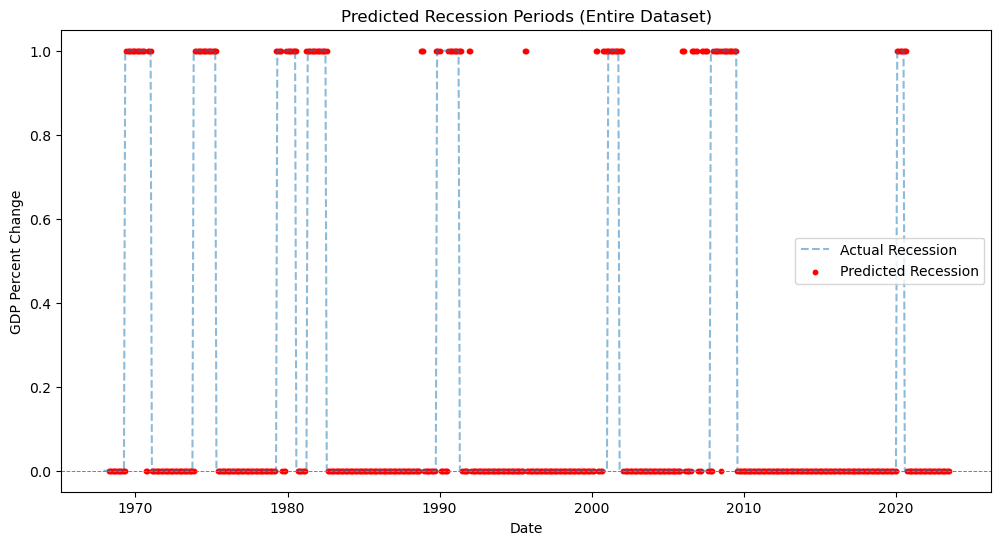

,Date,Recession Probability,Predicted Recession
0,1968-03-31,0.000782,0
1,1968-04-30,0.011847,0
2,1968-05-31,0.000442,0
3,1968-06-30,0.000633,0
4,1968-07-31,0.008896,0


In [46]:
from tensorflow.keras.models import load_model

# Redefine create_sequences function
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i + window_size].values)
        y.append(target.iloc[i + window_size])  # Align target with the end of the sequence
    return np.array(X), np.array(y)

# Load and preprocess the dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

# Prepare data to be predicted on
std_scaler = joblib.load('std_scaler.pkl')
yield_scaler = joblib.load('yield_scaler.pkl')
standard_scaler_columns = ['Slope', 'LongTermRate' ]
min_max_scaler_columns = ['ZeroCouponYield1Y', 'ZeroCouponYield10Y']

# Apply StandardScaler to selected columns
data[standard_scaler_columns] = std_scaler.fit_transform(data[standard_scaler_columns])
data[min_max_scaler_columns] = yield_scaler.transform(data[min_max_scaler_columns].values.flatten().reshape(-1, 1)).reshape(len(data), 2)


X_full_seq, y_full_seq = create_sequences(
    data.drop(columns=['Recession']),
    data['Recession'],
    window_size
)

best_model = load_model('best_classification_model.h5')


# Predict recession probabilities on the entire dataset
recession_probabilities_full = best_model.predict(X_full_seq)

# Convert probabilities to binary predictions (threshold = 0.5)
recession_predictions_full = (recession_probabilities_full >= 0.).astype(int).flatten()

# Map predictions back to the original dates (align with window end dates)
recession_dates_full = data.index[window_size:]  # Dates corresponding to the sequences

# Create a DataFrame with predicted recession dates and probabilities
recession_results_full = pd.DataFrame({
    'Date': recession_dates_full,
    'Recession Probability': recession_probabilities_full.flatten(),
    'Predicted Recession': recession_predictions_full
})

# Visualize the results
import matplotlib.pyplot as plt

# Plot a relevant economic indicator (e.g., GDP)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Recession'], label='Actual Recession', linestyle='--', alpha=0.5)
plt.scatter(data.index[window_size:], recession_predictions_full, label='Predicted Recession', color='red', s=10)
plt.plot()


# Add labels and legend
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Zero line for reference
plt.title('Predicted Recession Periods (Entire Dataset)')
plt.xlabel('Date')
plt.ylabel('GDP Percent Change')
plt.legend()
plt.show()



Accuracy: 0.89
Precision: 0.64
Recall: 0.95
F1-Score: 0.76

Confusion Matrix:
[[475  66]
 [  6 117]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       541
         1.0       0.64      0.95      0.76       123

    accuracy                           0.89       664
   macro avg       0.81      0.91      0.85       664
weighted avg       0.92      0.89      0.90       664



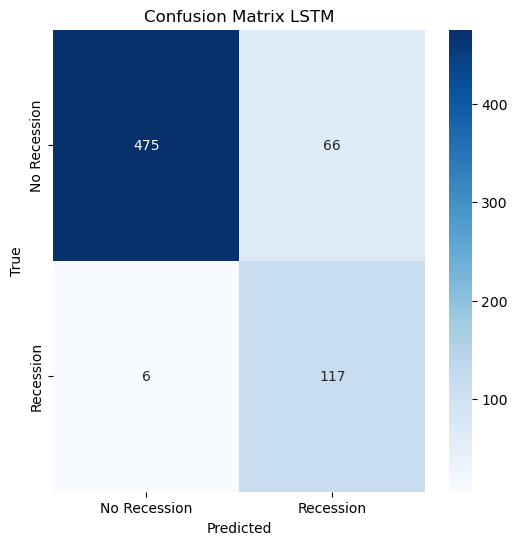

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# True labels and predicted labels
y_true = data['Recession'][window_size:]  # True recession labels (aligned with predictions)
y_pred = recession_predictions_full  # Predicted recession labels

# Classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Recession", "Recession"],
            yticklabels=["No Recession", "Recession"])
plt.title("Confusion Matrix LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
